In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [3]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [9]:
DATE_FORMAT = "%m/%d/%Y %H:%M"

In [10]:
dateparse = lambda x: pd.datetime.strptime(x, DATE_FORMAT)
infile = 'adapt_csv.csv'
df = pd.read_csv(infile, parse_dates=['timestamp'], date_parser=dateparse)

ValueError: time data '2018-09-23 20:44:00' does not match format '%m/%d/%Y %H:%M'

In [11]:
df = pd.read_csv(infile)

In [13]:
df.shape

(199, 27)

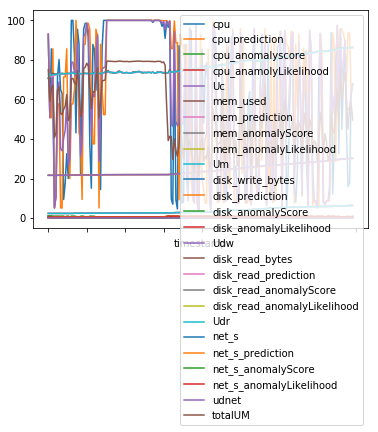

In [14]:
df.set_index('timestamp', inplace=True)

df.plot()

In [27]:
shift_second = 2
shift_steps = 1  * 2

In [28]:
df_targets = df.shift(-shift_steps)

In [29]:
df.head(shift_steps + 5)


,cpu,cpu prediction,cpu_anomalyscore,cpu_anamolyLikelihood,Uc,mem_used,mem_prediction,mem_anomalyScore,mem_anomalyLikelihood,Um,...,disk_read_prediction,disk_read_anomalyScore,disk_read_anomalyLikelihood,Udr,net_s,net_s_prediction,net_s_anomalyScore,net_s_anomalyLikelihood,udnet,totalUM
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-23 20:44:00,93.0,93.0,1.0,0.5,93.00,70.6,70.600000,1,0.5,70.600000,...,2.346488,1,0.5,2.346488,0.000006,0.000006,1,0.5,0.000006,75.024296
2018-09-23 20:44:00,50.8,50.8,1.0,0.5,50.80,73.1,73.100000,1,0.5,73.100000,...,2.346488,1,0.5,2.346488,0.000006,0.000006,1,0.5,0.000006,59.144771
2018-09-23 20:44:00,85.6,50.8,1.0,0.5,68.20,72.9,71.350000,1,0.5,72.125000,...,2.346488,1,0.5,2.346488,0.000006,0.000006,1,0.5,0.000006,65.714859
2018-09-23 20:44:00,57.7,85.6,1.0,0.5,71.65,73.2,71.815000,0,0.5,72.507500,...,2.346488,0,0.5,2.346488,0.000006,0.000006,0,0.5,0.000006,67.248153
2018-09-23 20:44:00,5.1,5.1,1.0,0.5,5.10,72.9,72.230500,0,0.5,72.565250,...,2.346488,0,0.5,2.346488,0.000006,0.000006,0,0.5,0.000006,40.652073
2018-09-23 20:44:00,11.1,11.1,1.0,0.5,11.10,72.9,72.431350,0,0.5,72.665675,...,2.346488,0,0.5,2.346488,0.000006,0.000006,0,0.5,0.000006,43.092544
2018-09-23 20:44:00,71.4,57.7,1.0,0.5,64.55,72.9,72.571945,0,0.5,72.735973,...,2.346488,0,0.5,2.346488,0.000006,0.000006,0,0.5,0.000006,64.500930


In [30]:
df_targets.head(5)

,cpu,cpu prediction,cpu_anomalyscore,cpu_anamolyLikelihood,Uc,mem_used,mem_prediction,mem_anomalyScore,mem_anomalyLikelihood,Um,...,disk_read_prediction,disk_read_anomalyScore,disk_read_anomalyLikelihood,Udr,net_s,net_s_prediction,net_s_anomalyScore,net_s_anomalyLikelihood,udnet,totalUM
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-23 20:44:00,85.6,50.8,1.0,0.5,68.20,72.9,71.350000,1.0,0.5,72.125000,...,2.346488,1.0,0.5,2.346488,0.000006,0.000006,1.0,0.5,0.000006,65.714859
2018-09-23 20:44:00,57.7,85.6,1.0,0.5,71.65,73.2,71.815000,0.0,0.5,72.507500,...,2.346488,0.0,0.5,2.346488,0.000006,0.000006,0.0,0.5,0.000006,67.248153
2018-09-23 20:44:00,5.1,5.1,1.0,0.5,5.10,72.9,72.230500,0.0,0.5,72.565250,...,2.346488,0.0,0.5,2.346488,0.000006,0.000006,0.0,0.5,0.000006,40.652073
2018-09-23 20:44:00,11.1,11.1,1.0,0.5,11.10,72.9,72.431350,0.0,0.5,72.665675,...,2.346488,0.0,0.5,2.346488,0.000006,0.000006,0.0,0.5,0.000006,43.092544
2018-09-23 20:44:00,71.4,57.7,1.0,0.5,64.55,72.9,72.571945,0.0,0.5,72.735973,...,2.346488,0.0,0.5,2.346488,0.000006,0.000006,0.0,0.5,0.000006,64.500930


In [31]:
df_targets.tail(5)

,cpu,cpu prediction,cpu_anomalyscore,cpu_anamolyLikelihood,Uc,mem_used,mem_prediction,mem_anomalyScore,mem_anomalyLikelihood,Um,...,disk_read_prediction,disk_read_anomalyScore,disk_read_anomalyLikelihood,Udr,net_s,net_s_prediction,net_s_anomalyScore,net_s_anomalyLikelihood,udnet,totalUM
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-23 23:27:00,17.6,93.5892,0.125,0.605328,55.5946,86.2,86.036212,0.0,0.641741,86.118106,...,6.195122,0.0,0.641741,6.278812,0.000006,0.000006,0.0,0.641741,0.000006,56.135330
2018-09-23 23:27:00,62.9,62.9000,0.075,0.772446,62.9000,86.3,86.085349,0.0,0.605328,86.192674,...,6.245336,0.0,0.605328,6.365780,0.000006,0.000006,0.0,0.605328,0.000006,58.120245
2018-09-23 23:29:00,67.9,67.9000,0.150,0.757708,67.9000,86.4,86.149744,0.0,0.772446,86.274872,...,6.317603,0.0,0.772446,6.401913,0.000006,0.000006,0.0,0.772446,0.000006,49.584472
2018-09-23 23:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-23 23:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
x_data = df.values[0:-shift_steps]

In [33]:
print(type(x_data))
print("Shape:", x_data.shape)

<type 'numpy.ndarray'>
('Shape:', (197, 26))


In [34]:
y_data = df_targets.values[:-shift_steps]

In [35]:
print(type(y_data))
print("Shape:", y_data.shape)

<type 'numpy.ndarray'>
('Shape:', (197, 26))


In [36]:
num_data = len(x_data)
num_data

197

In [37]:
train_split = 0.9

In [38]:
num_train = int(train_split * num_data)
num_train

177

In [39]:
num_test = num_data - num_train
num_test

20

In [40]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

197

In [41]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

197

In [42]:
num_x_signals = x_data.shape[1]
num_x_signals

26

In [43]:
num_y_signals = y_data.shape[1]
num_y_signals

26

In [44]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

('Min:', 0.0)
('Max:', 100.0)


In [45]:
x_scaler = MinMaxScaler()

In [46]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [47]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

('Min:', 0.0)
('Max:', 1.0000000000000002)


In [48]:
x_test_scaled = x_scaler.transform(x_test)

In [49]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [50]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(177, 26)
(177, 26)


In [51]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [52]:
batch_size = 256

In [65]:
sequence_length =  60 
sequence_length

60

In [66]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [67]:
x_batch, y_batch = next(generator)

In [68]:
print(x_batch.shape)
print(y_batch.shape)

(256, 60, 26)
(256, 60, 26)


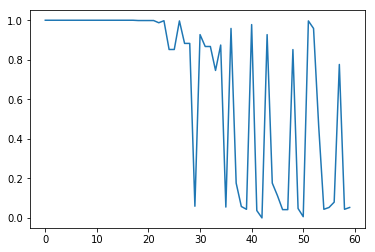

In [69]:
batch = 1   # First sequence in the batch.
signal = 1  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

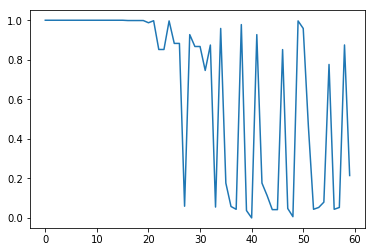

In [70]:
seq = y_batch[batch, :, signal]
plt.plot(seq)




In [71]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [72]:
model = Sequential()

In [73]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [74]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [75]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [76]:
warmup_steps = 50

In [77]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [78]:
optimizer = RMSprop(lr=1e-3)

In [79]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         827904    
_________________________________________________________________
dense (Dense)                (None, None, 26)          13338     
Total params: 841,242
Trainable params: 841,242
Non-trainable params: 0
_________________________________________________________________


In [81]:
path_checkpoint = 'cpu_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [82]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [83]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)



In [84]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [85]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [86]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0399
Epoch 00001: val_loss improved from inf to 0.00000, saving model to cpu_checkpoint.keras
100/100 [==============================] - 194s 2s/step - loss: 0.0397 - val_loss: 0.0000e+00
Epoch 2/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0197
Epoch 00002: val_loss did not improve from 0.00000

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000475.
100/100 [==============================] - 192s 2s/step - loss: 0.0196 - val_loss: 0.0000e+00
Epoch 3/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0086
Epoch 00003: val_loss did not improve from 0.00000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 195s 2s/step - loss: 0.0086 - val_loss: 0.0000e+00
Epoch 4/20
 99/100 [============================>.] - ETA: 1s - loss: 0.0055
Epoch 00004: val_loss did not improve from 0.00000
100/100 [=================

In [87]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [88]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 15ms/step


In [89]:
print("loss (test-set):", result)

('loss (test-set):', 0.0)


In [90]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [91]:
target_names = ['Pred CPU']

In [92]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

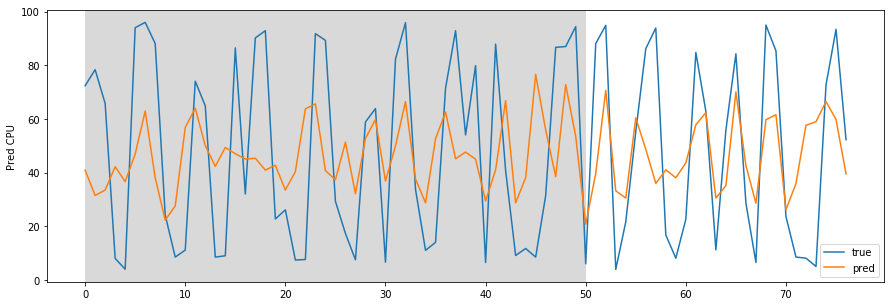

In [94]:
plot_comparison(start_idx=100, length=200, train=True)

In [95]:
tf.reset_default_graph()